# Previsão de renda

### 4 elementos importantes
- Esse notebook
- Streamlit com as análises
- Seu Github com o projeto
- Vídeo no readme do github mostrando o streamlit

## Etapa 1 CRISP - DM: Entendimento do negócio

O objetivo deste projeto é criar um modelo preditivo para estimar a renda anual dos indivíduos com base em dados demográficos e socioeconômicos. Essa previsão permitirá à empresa segmentar o mercado de maneira mais eficaz, melhorar a análise de crédito e personalizar produtos e serviços, resultando em campanhas de marketing mais precisas e na redução da inadimplência.

## Etapa 2 Crisp-DM: Entendimento dos dados


### Dicionário de dados

Os dados estão dispostos em uma tabela com uma linha para cada cliente, e uma coluna para cada variável armazenando as características desses clientes. Colocamos uma cópia o dicionário de dados (explicação dessas variáveis) abaixo neste notebook:


| Variável                | Descrição                                           | Tipo         |
| ----------------------- |:---------------------------------------------------:| ------------:|
| data_ref                |  Data = AAAA-mm-dd                                  | TEXTO        |
| id_cliente              |  Código identificador do cliente                    | INTEIRO      |
| sexo                    |  F = 'Feminino' \| M = 'Masculino'                  | TEXTO        |
| posse_de_veiculo        |  Se possui veículo (True \| False)                  | BINÁRIA      |
| posse_de_imovel         |  Se possui Imóvel (True \| False)                   | BINÁRIA      |
| qtd_filhos              |  Quantidade de filhos                               | INTEIRO      |
| tipo_renda              |  Tipo de renda (ex: assaliariado, autônomo etc)     | TEXTO        |
| educacao                |  Nível de educação (ex: secundário, superior etc)   | TEXTO        |
| estado_civil            |  Estado civil (ex: solteiro, casado etc)            | TEXTO        |
| tipo_residencia         |  tipo de residência (ex: casa/apartamento etc)      | TEXTO        |
| idade                   |  Idade do cliente em anos                           | INTEIRO      |
| tempo_emprego           |  Tempo de emprego em anos                           | DECIMAL      |
| qt_pessoas_residencia   |  Quantidade de pessoas na residência                | DECIMAL      |
| renda                   |  Renda mensal                                       | DECIMAL      |





#### Carregando os pacotes
É considerado uma boa prática carregar os pacotes que serão utilizados como a primeira coisa do programa.

In [38]:
import joblib

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport

import statsmodels.api as sm
from sklearn.linear_model import Ridge
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

%matplotlib inline

In [39]:
import warnings
# Suprimindo todos os UserWarnings temporariamente
warnings.filterwarnings("ignore", category=UserWarning)

- ### Funções

In [40]:
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.05, 
                       threshold_out = 0.05, 
                       verbose=True):
    included = list(initial_list)
    while True:
        changed=False
        # Adiciona novas variáveis
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Adicionando variável: {:30} com p-value {:.6}'.format(best_feature, best_pval))
        # Remove variáveis
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # Use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Removendo variável: {:30} com p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

#### Carregando os dados
O comando pd.read_csv é um comando da biblioteca pandas (pd.) e carrega os dados do arquivo csv indicado para um objeto *dataframe* do pandas.

In [41]:
renda = pd.read_csv('./input/previsao_de_renda.csv')

# removendo variaveis que não serão analisadas
renda.drop(columns=['Unnamed: 0', 'id_cliente'], inplace=True)

# removendo valores faltantes
renda.dropna(inplace=True)

# removendo valores duplicados
renda.drop_duplicates(inplace=True)

# transformando variavel data_ref para datetime
renda['data_ref'] = pd.to_datetime(renda['data_ref'])

renda.info()
renda.head(5)

<class 'pandas.core.frame.DataFrame'>
Index: 12090 entries, 0 to 14999
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   data_ref               12090 non-null  datetime64[ns]
 1   sexo                   12090 non-null  object        
 2   posse_de_veiculo       12090 non-null  bool          
 3   posse_de_imovel        12090 non-null  bool          
 4   qtd_filhos             12090 non-null  int64         
 5   tipo_renda             12090 non-null  object        
 6   educacao               12090 non-null  object        
 7   estado_civil           12090 non-null  object        
 8   tipo_residencia        12090 non-null  object        
 9   idade                  12090 non-null  int64         
 10  tempo_emprego          12090 non-null  float64       
 11  qt_pessoas_residencia  12090 non-null  float64       
 12  renda                  12090 non-null  float64       
dtypes: boo

,data_ref,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
0,2015-01-01,F,False,True,0,Empresário,Secundário,Solteiro,Casa,26,6.602740,1.0,8060.34
1,2015-01-01,M,True,True,0,Assalariado,Superior completo,Casado,Casa,28,7.183562,2.0,1852.15
2,2015-01-01,F,True,True,0,Empresário,Superior completo,Casado,Casa,35,0.838356,2.0,2253.89
3,2015-01-01,F,False,True,1,Servidor público,Superior completo,Casado,Casa,30,4.846575,3.0,6600.77
4,2015-01-01,M,True,False,0,Assalariado,Secundário,Solteiro,Governamental,33,4.293151,1.0,6475.97


#### Entendimento dos dados - Univariada
Nesta etapa tipicamente avaliamos a distribuição de todas as variáveis. 

- ### Distribuição da variavel ["sexo"]

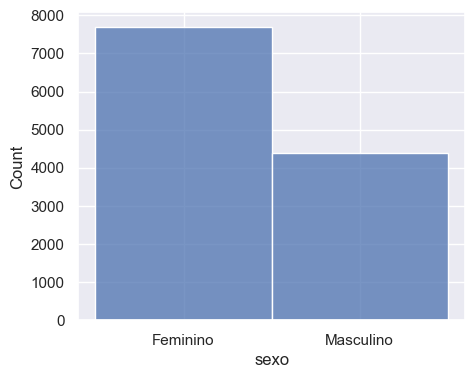

In [42]:
sns.set()
plt.figure(figsize=(5,4))
sns.histplot(renda,
             x="sexo"
            ).set_xticklabels(['Feminino', 'Masculino']
            )
plt.show()

- ### Distribuição da variavel ["posse_de_veiculo"]

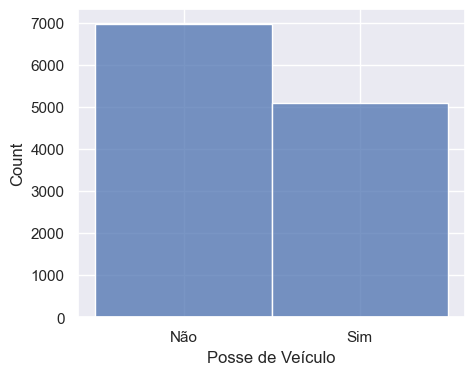

In [43]:
plt.figure(figsize=(5,4))
sns.histplot(renda,
             x="posse_de_veiculo",
             bins=[-0.5, 0.5, 1.5],
            ).set_xticklabels(['Não', 'Sim']
            )
plt.xticks(ticks=(0,1))
plt.xlabel('Posse de Veículo')
plt.show()

- ### Distribuição da variavel ["posse_de_imovel"]

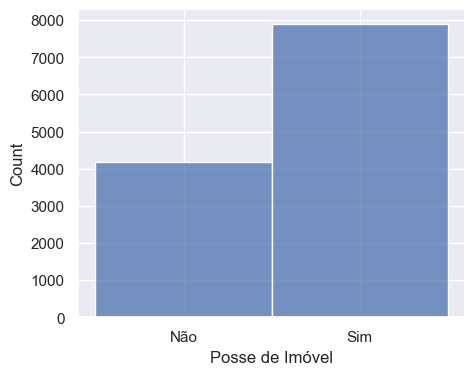

In [44]:
plt.figure(figsize=(5,4))
sns.histplot(renda,
             x="posse_de_imovel",
             bins=[-0.5, 0.5, 1.5],
            ).set_xticklabels(['Não', 'Sim']
            )
plt.xticks(ticks=(0,1))
plt.xlabel('Posse de Imóvel')
plt.show()

- ### Distribuição da variavel ["qtd_filhos"]

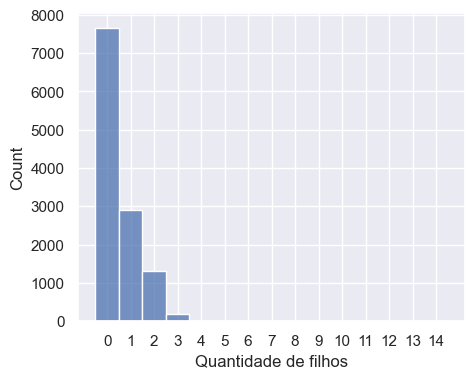

In [45]:
plt.figure(figsize=(5,4))
sns.histplot(renda,
             x='qtd_filhos',
             binrange=(min(renda.qtd_filhos)-0.5,
                       max(renda.qtd_filhos)+0.5),
             binwidth=1)
plt.xticks(ticks=[x for x in range(0,15)])
plt.xlabel('Quantidade de filhos')
plt.show()

- ### Distribuição da variavel ["tipo_renda"]

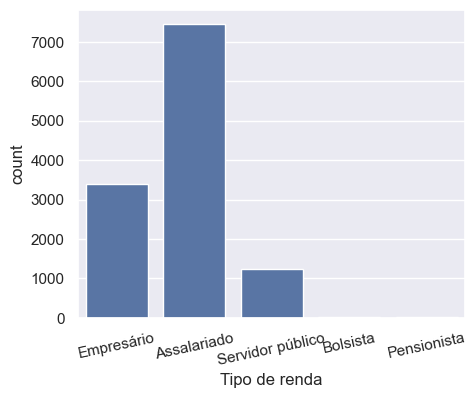

In [46]:
plt.figure(figsize=(5,4))
sns.countplot(renda,
              x="tipo_renda")
plt.xlabel('Tipo de renda')
plt.xticks(rotation=12)
plt.show()

- ### Distribuição da variavel ["educacao"]

Text(0.5, 0, 'Educação')

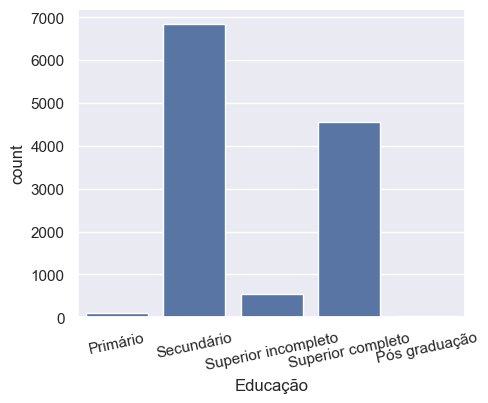

In [47]:
plt.figure(figsize=(5,4))
sns.countplot(renda,
              x="educacao",
              order=['Primário',
                     'Secundário',
                     'Superior incompleto',
                     'Superior completo',
                     'Pós graduação'])
plt.xticks(rotation=12)
plt.xlabel('Educação')

- ### Distribuição da variavel ["estado_civil"]

Text(0.5, 0, 'Estado civil')

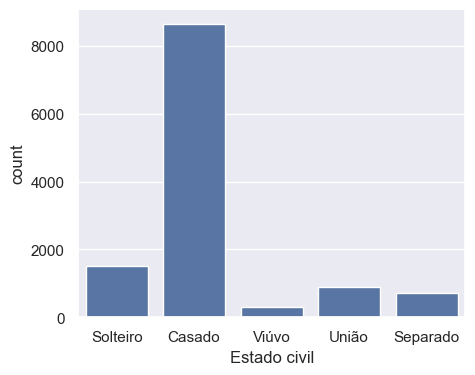

In [48]:
plt.figure(figsize=(5,4))
sns.countplot(renda,
              x="estado_civil")
plt.xlabel('Estado civil')

- ### Distribuição da variavel ["tipo_residencia"]

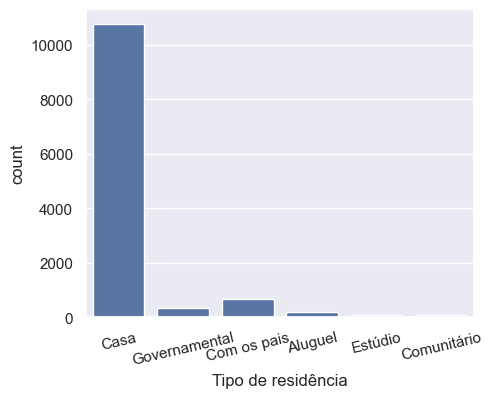

In [49]:
plt.figure(figsize=(5,4))
sns.countplot(renda,
              x="tipo_residencia")
plt.xlabel('Tipo de residência')
plt.xticks(rotation=13)
plt.show()

- ### Distribuição da variavel ["idade"]

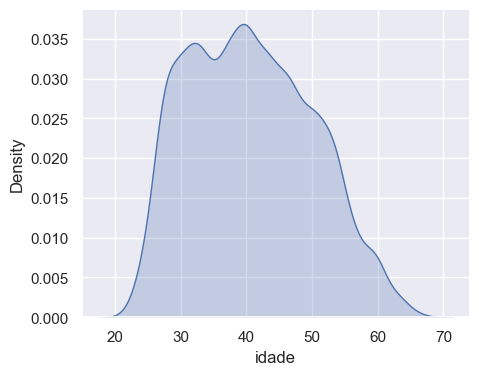

In [50]:
plt.figure(figsize=(5,4))
sns.kdeplot(renda,
            x="idade",
            fill=True
           )
plt.show()

- ### Distribuição da variavel ["tempo_emprego"]

Text(0.5, 0, 'Tempo de emprego (em anos)')

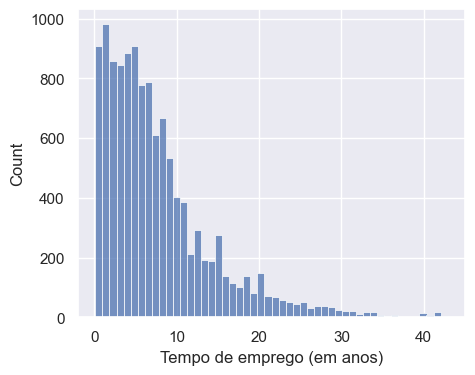

In [51]:
plt.figure(figsize=(5,4))
sns.histplot(renda,
             x="tempo_emprego",
             bins=50
            )
plt.xlabel('Tempo de emprego (em anos)')

- ### Distribuição da variavel ["qt_pessoas_residencia"]

Text(0.5, 0, 'Quantidade de pessoas na residência')

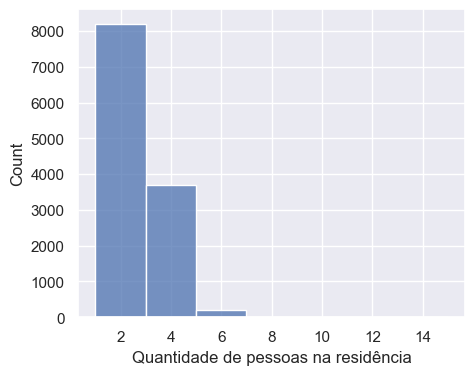

In [52]:
plt.figure(figsize=(5,4))
sns.histplot(renda,
             x="qt_pessoas_residencia",
             bins=7)
plt.xlabel("Quantidade de pessoas na residência")

### Entendimento dos dados - Bivariadas




- # Algumas analises para variáveis categóricas e numéricas

- ### Matriz de correlação para analisar a correlação das variáveis numéricas com a variável renda.

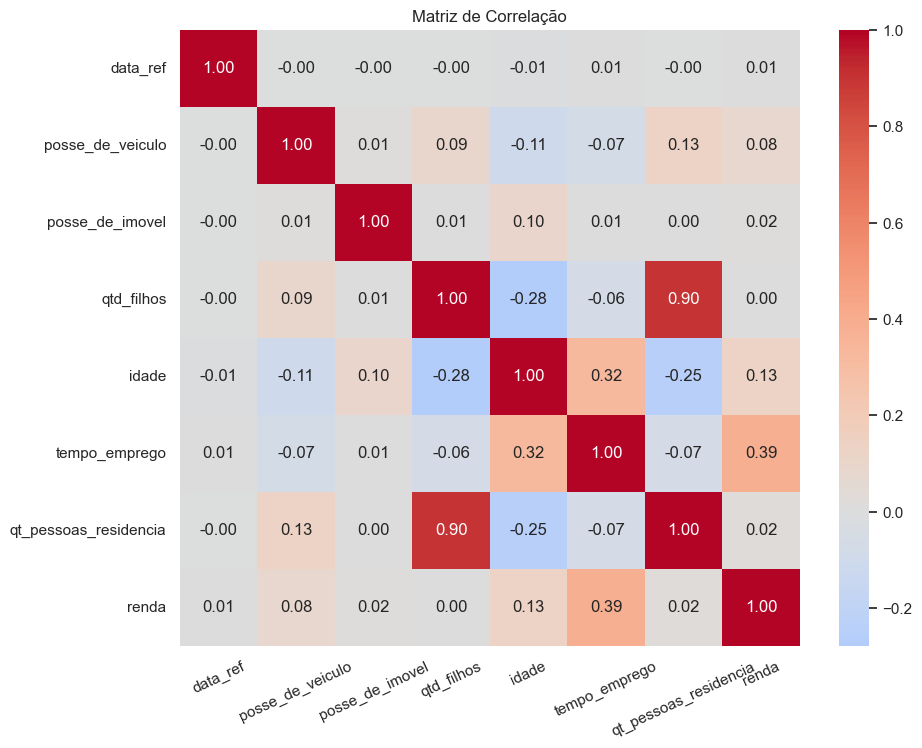

In [53]:
correlation_matrix = renda.drop(['sexo',
                                 'tipo_renda',
                                 'educacao',
                                 'estado_civil',
                                 'tipo_residencia',],
                                axis=1).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix,
            annot=True,
            fmt=".2f",
            cmap='coolwarm',
            center=0
            )
plt.title('Matriz de Correlação')
plt.xticks(rotation=25)
plt.show()

- ### Média da renda por tipo de renda

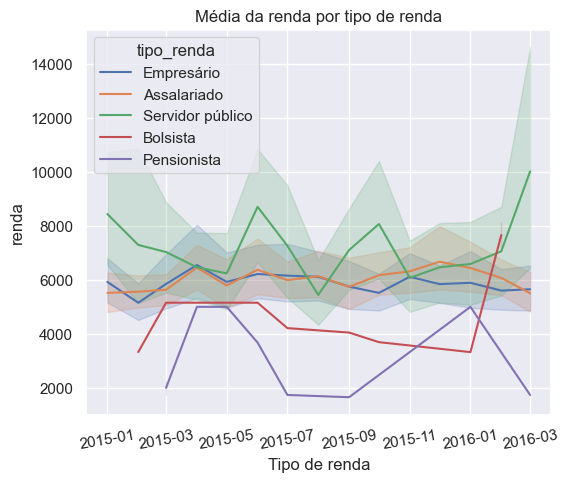

In [54]:
plt.figure(figsize=(6,5))
sns.lineplot(data=renda,
             x='data_ref',
             y='renda',
             hue='tipo_renda'
            )
plt.title('Média da renda por tipo de renda')
plt.xticks(rotation=10)
plt.xlabel('Tipo de renda')
plt.show()

- ### Média da renda por estado civil

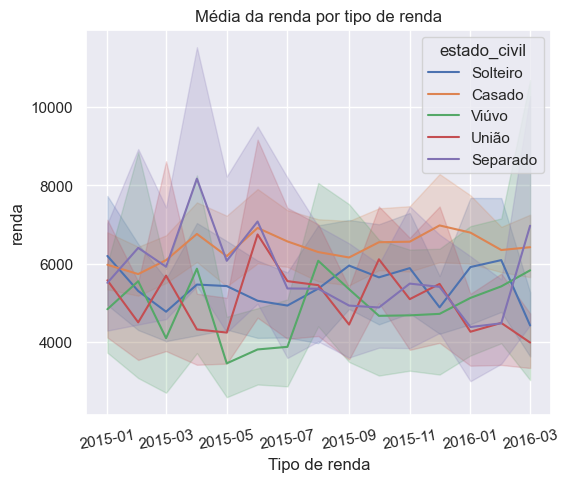

In [55]:
plt.figure(figsize=(6,5))
sns.lineplot(data=renda,
             x='data_ref',
             y='renda',
             hue='estado_civil'
            )
plt.title('Média da renda por tipo de renda')
plt.xticks(rotation=10)
plt.xlabel('Tipo de renda')
plt.show()

- ### Média da renda por tipo de residência pelo tempo

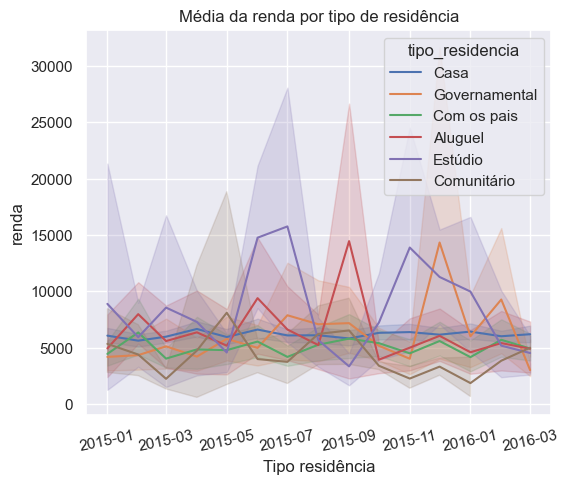

In [56]:
plt.figure(figsize=(6,5))
sns.lineplot(data=renda,
             x='data_ref',
             y='renda',
             hue='tipo_residencia'
            )
plt.xticks(rotation=12)
plt.title('Média da renda por tipo de residência')
plt.xlabel('Tipo residência')
plt.show()

- ### Média da renda por educação

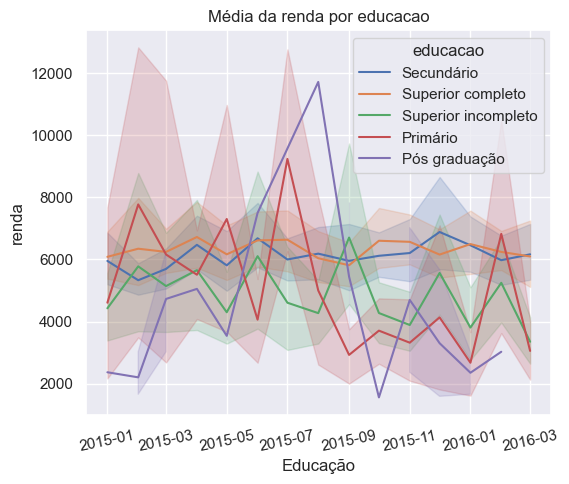

In [57]:
plt.figure(figsize=(6,5))
sns.lineplot(data=renda,
             x='data_ref',
             y='renda',
             hue='educacao'
            )
plt.xticks(rotation=12)
plt.title('Média da renda por educacao')
plt.xlabel('Educação')
plt.show()

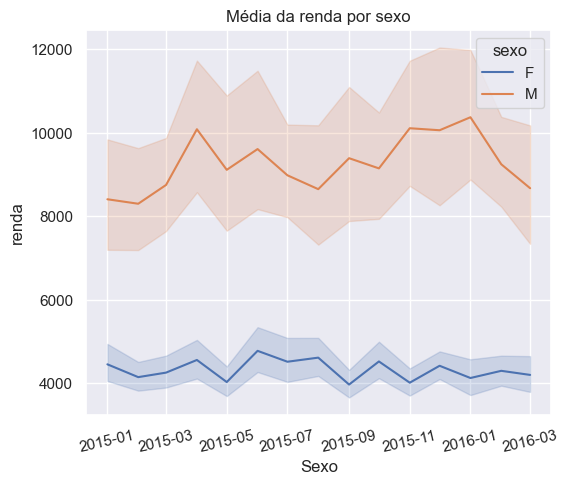

In [58]:
plt.figure(figsize=(6,5))
sns.lineplot(data=renda,
             x='data_ref',
             y='renda',
             hue='sexo'
            )
plt.xticks(rotation=13)
plt.title('Média da renda por sexo')
plt.xlabel('Sexo')
plt.show()

## Etapa 3 Crisp-DM: Preparação dos dados
Nessa etapa realizamos tipicamente as seguintes operações com os dados:

 - **seleção**: Já temos os dados selecionados adequadamente?
 - **limpeza**: Precisaremos identificar e tratar dados faltantes
 - **construção**: construção de novas variáveis
 - **integração**: Temos apenas uma fonte de dados, não é necessário integração
 - **formatação**: Os dados já se encontram em formatos úteis?



In [59]:
enc_renda = (pd.get_dummies(data=renda)
    .drop('data_ref', axis=1)
    .astype('float')
)
enc_renda

,posse_de_veiculo,posse_de_imovel,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda,sexo_F,sexo_M,tipo_renda_Assalariado,...,estado_civil_Separado,estado_civil_Solteiro,estado_civil_União,estado_civil_Viúvo,tipo_residencia_Aluguel,tipo_residencia_Casa,tipo_residencia_Com os pais,tipo_residencia_Comunitário,tipo_residencia_Estúdio,tipo_residencia_Governamental
0,0.0,1.0,0.0,26.0,6.602740,1.0,8060.34,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1.0,1.0,0.0,28.0,7.183562,2.0,1852.15,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.0,1.0,0.0,35.0,0.838356,2.0,2253.89,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,1.0,1.0,30.0,4.846575,3.0,6600.77,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,33.0,4.293151,1.0,6475.97,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14994,1.0,0.0,0.0,32.0,9.849315,2.0,1592.57,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
14995,0.0,1.0,0.0,48.0,13.887671,1.0,7990.58,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
14997,1.0,1.0,0.0,45.0,7.832877,2.0,604.82,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
14998,1.0,0.0,0.0,36.0,4.298630,2.0,3352.27,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


## Etapa 4 Crisp-DM: Modelagem
Nessa etapa que realizaremos a construção do modelo. Os passos típicos são:
- Selecionar a técnica de modelagem
- Desenho do teste
- Avaliação do modelo


In [60]:
X, y = enc_renda.drop(['renda'], axis=1), enc_renda['renda']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=9)

- ### Utilizando o método stepwise para automatizar o processo de seleção de variáveis

In [61]:
cols_stepwise = stepwise_selection(X_train, y_train)

X_train_stepwise = sm.add_constant(X_train[cols_stepwise])
X_test_stepwise = sm.add_constant(X_test[cols_stepwise])

m_stepwise = sm.OLS(y_train, X_train_stepwise).fit()
pred_stepwise = m_stepwise.predict(X_test_stepwise)

r2_stepwise = r2_score(y_test, pred_stepwise)

print(f'R² no conjunto de teste com modelo stepwise: {r2_stepwise}')

Adicionando variável: tempo_emprego                  com p-value 0.0
Adicionando variável: sexo_M                         com p-value 1.7509e-255
Adicionando variável: sexo_F                         com p-value 2.25927e-126
Adicionando variável: tipo_renda_Empresário          com p-value 1.35519e-05
Removendo variável: sexo_M                         com p-value 0.523548
Adicionando variável: idade                          com p-value 1.20737e-05
Adicionando variável: sexo_M                         com p-value 1.48676e-109
Adicionando variável: educacao_Superior completo     com p-value 0.00079194
Adicionando variável: estado_civil_Casado            com p-value 0.00553416
R² no conjunto de teste com modelo stepwise: 0.22972683517706272


- ### Utilizando o método Ridge para encontrar o melhor alpha

In [62]:
alphas = [0, 0.001, 0.005, 0.01, 0.05, 0.1]

melhor_alpha = None
melhor_r2 = -float('inf')

for alpha in alphas:
    m_rid = Ridge(alpha=alpha)
    m_rid.fit(X_train[cols_stepwise], y_train)

    pred = m_rid.predict(X_test[cols_stepwise])

    r2 = r2_score(y_test, pred)

    if r2 > melhor_r2:
        melhor_r2 = r2
        melhor_alpha = alpha

print(f'Melhor alpha: {melhor_alpha}')
print(f'Melhor R²: {melhor_r2}')

Melhor alpha: 0.1
Melhor R²: 0.22972918719627933


### Rodando o modelo


In [63]:
m_tree = RandomForestRegressor(random_state=9, ccp_alpha=melhor_alpha)
m_tree.fit(X_train[cols_stepwise], y_train)

RandomForestRegressor(ccp_alpha=0.1, random_state=9)

## Etapa 5 Crisp-DM: Avaliação dos resultados


In [64]:
y_pred = m_tree.predict(X_train[cols_stepwise])

r_squared = r2_score(y_train, y_pred)
print("R² da random forest na base de treino:", r_squared)

y_pred = m_tree.predict(X_test[cols_stepwise])

r_squared = r2_score(y_test, y_pred)
print("R² da random forest na base de teste:", r_squared)

R² da random forest na base de treino: 0.7845636604062758
R² da random forest na base de teste: 0.33912628130485134


In [65]:
renda['renda_predict'] = (
    m_tree.predict(X[cols_stepwise])
)
renda[['renda', 'renda_predict']]

,renda,renda_predict
0,8060.34,5372.880271
1,1852.15,4264.131652
2,2253.89,2137.986829
3,6600.77,3953.663053
4,6475.97,6234.571445
...,...,...
14994,1592.57,6624.904575
14995,7990.58,7682.192516
14997,604.82,2017.388092
14998,3352.27,4350.818522


## Etapa 6 Crisp-DM: Implantação
Nessa etapa colocamos em uso o modelo desenvolvido, normalmente implementando o modelo desenvolvido em um motor que toma as decisões com algum nível de automação.

In [66]:
joblib.dump(m_tree, './modelo_treinado.pkl')

['./modelo_treinado.pkl']

In [67]:
entrada = pd.DataFrame([{
    'sexo':'M',
    'idade':30,
    'educacao':'Superior Completo',
    'tempo_emprego':0,
    'posse_de_veiculo':True,
    'posse_de_imovel':True,
    'qtd_filhos':1,
    'qt_pessoas_residencia':1,
    'tipo_renda':'Assalariado',
    'estado_civil':'Solteiro',
    'tipo_residencia':'Casa'
}])
entrada = (pd.get_dummies(entrada,
                          columns=['sexo',
                                   'tipo_renda',
                                   'tipo_residencia',
                                   'estado_civil',
                                   'educacao',]).astype('float')
          )
print(f" Renda aproximada: R${str(np.round(m_tree.predict(pd.concat([X, entrada]).fillna(0).tail(1)[cols_stepwise]
)[0], 2)).replace('.', ',')}")

 Renda aproximada: R$4635,31
